# About

This script compares the performance of the two oracles live on StarkNet for the ETH/USD feed.

Empiric emits events every time a source sends new data on-chain which lets anyone audit their public track record going back months. They have emitted over 3.5M events to date.

Stork contracts can be benchmarked by repeatedly polling their values. We ran a script that pulled data every 3 minutes (their update frequency) and stored it for analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
time_window = (1660360400, 1660490000) # 36 hours

In [7]:
stork = pd.read_csv("stork_data.csv")
stork = stork.drop(columns="Unnamed: 0")
stork = stork.drop_duplicates().reset_index(drop=True)
stork["datetime"] = pd.to_datetime(stork["timestamp"], unit="s")
stork["value"] = stork["value"].apply(lambda x: float(x)/(10**18))
stork = stork[(stork["timestamp"] > time_window[0]) & (stork["timestamp"] <= time_window[1])].reset_index(drop=True)
stork.head()

,asset,value,timestamp,publisher,type,datetime
0,19514442401534788,1973.443049,1660361410,25789180169021501187677569358,1953063787,2022-08-13 03:30:10
1,19514442401534788,1976.379371,1660361950,25789180169021501187677569358,1953063787,2022-08-13 03:39:10
2,19514442401534788,1979.560802,1660362130,25789180169021501187677569358,1953063787,2022-08-13 03:42:10
3,19514442401534788,1982.577160,1660362670,25789180169021501187677569358,1953063787,2022-08-13 03:51:10
4,19514442401534788,1985.043269,1660363030,25789180169021501187677569358,1953063787,2022-08-13 03:57:10


In [8]:
len(stork)

277

In [12]:
empiric = pd.read_csv("empiric-events.csv")
empiric = empiric.drop(columns="Unnamed: 0")
empiric["datetime"] = pd.to_datetime(empiric["datetime"])
empiric = empiric[empiric["key"] == "eth/usd"]
empiric.loc[:, ["transaction_hash",]] = empiric["transaction_hash"].apply(lambda x: hex(int(x)))
empiric = empiric[(empiric["timestamp"] > time_window[0]) & (empiric["timestamp"] <= time_window[1])].reset_index(drop=True)
empiric.head()

,key,value,source,publisher,timestamp,transaction_hash,datetime
0,eth/usd,1971.92,gemini,empiric,1660360404,0x1ca800ea4f93c13d841ead5237a7de7d1e135f8918fe...,2022-08-13 03:13:24
1,eth/usd,1971.80,ftx,empiric,1660360406,0x255c0577be0e2789727080406b3e2c2fdc90d1d1462e...,2022-08-13 03:13:26
2,eth/usd,1973.45,cex,empiric,1660360409,0x3495d71fc4b540731e3b6b6bf690c702ac0d502e86fd...,2022-08-13 03:13:29
3,eth/usd,1972.30,bitstamp,empiric,1660360414,0x26c6e6e1cad85efdd34625a99811021d57d34760bd34...,2022-08-13 03:13:34
4,eth/usd,1972.45,gemini,argent,1660360453,0x43da278fb0eaf2641414e85ad329982cdc1034f564ba...,2022-08-13 03:14:13


In [13]:
len(empiric)

27871

In [186]:
chainlink = pd.read_csv("chainlink.csv")
chainlink["datetime"] = pd.to_datetime(chainlink["timestamp"], unit="s")
chainlink = chainlink.drop(columns=["block_number", "round_id"])
chainlink = chainlink.rename(columns={"answer": "value"})
chainlink = chainlink[(chainlink["timestamp"] > time_window[0]) & (chainlink["timestamp"] <= time_window[1])].reset_index(drop=True)
chainlink.head()

,value,timestamp,datetime
0,1990.830000,1660424123,2022-08-13 20:55:23
1,1986.606769,1660427729,2022-08-13 21:55:29
2,1980.390000,1660431292,2022-08-13 22:54:52
3,1982.800000,1660434901,2022-08-13 23:55:01
4,1989.775099,1660438507,2022-08-14 00:55:07


In [20]:
len(chainlink)

70

In [ ]:
datasets = [(empiric, "Empiric"), (stork, "Stork"), (chainlink, "Chainlink")]

In [212]:
for dataset, label in datasets[:-1]:
    dataset = dataset.sort_values("datetime")
    dataset["previous_datetime"] = dataset.shift(1)["datetime"]
    dataset["time_diff"] = dataset["datetime"] - dataset["previous_datetime"]
    dataset["seconds_diff"] = dataset["time_diff"].apply(lambda x: x.seconds)
    print(label)
    print(dataset["seconds_diff"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    print("Outages")
    print(dataset[dataset["seconds_diff"] > 1200])

Empiric
count    27870.000000
mean         4.649480
std          8.407494
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
90%         14.000000
95%         23.000000
99%         40.000000
max        168.000000
Name: seconds_diff, dtype: float64
Outages
Empty DataFrame
Columns: [key, value, source, publisher, timestamp, transaction_hash, datetime, last_chainlink_timestamp, current_median, previous_datetime, time_diff, seconds_diff]
Index: []
Stork
count     276.000000
mean      463.047101
std       343.550618
min       171.000000
25%       180.000000
50%       360.000000
75%       541.000000
90%       900.000000
95%      1125.250000
99%      1664.000000
max      2341.000000
Name: seconds_diff, dtype: float64
Outages
            asset        value     timestamp                      publisher  \
7    1.951444e+16  1996.648492  1.660365e+09  25789180169021501187677569358   
11   1.951444e+16  1991.926367  1.660367e+09  25789180169021501187677569358  

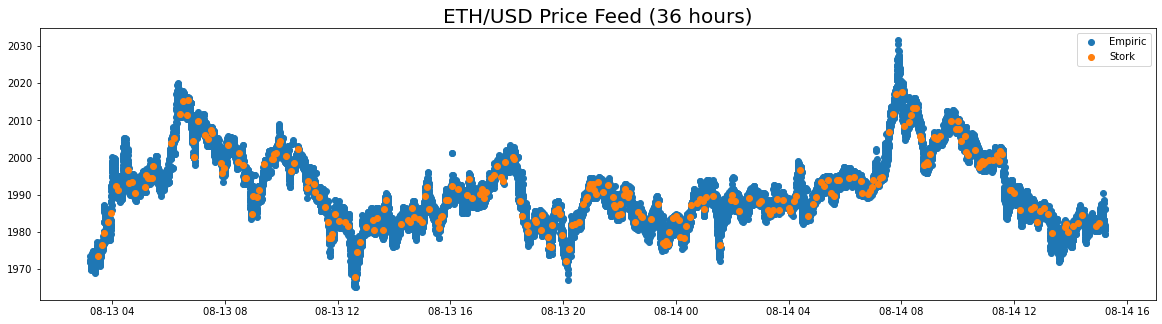

In [147]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets[:-1]:
    plt.scatter(dataset["datetime"], dataset["value"], label=label)

plt.title("ETH/USD Price Feed (36 hours)", fontsize=20)
plt.legend()
plt.show()

## Precision

In [196]:
# Need to aggregate - take the median of all the values currently available

from statistics import median

publisher_values = {}
empiric["current_median"] = 0
for i, row in empiric.iterrows():
    publisher_values[row["source"]] = row["value"]
    empiric.loc[i, "current_median"] = median(publisher_values.values())

In [197]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("timestamp").reset_index(drop=True)
empiric["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]
for i, row in empiric.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]

    empiric.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

In [203]:
combined_empiric = pd.merge(chainlink, empiric, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_empiric"])
combined_empiric["difference"] = combined_empiric["current_median"] - combined_empiric["value_chainlink"]
combined_empiric["percentage_difference"] = combined_empiric["difference"] / combined_empiric["value_chainlink"]
combined_empiric = combined_empiric[combined_empiric["timestamp_chainlink"] < combined_empiric["timestamp_empiric"]]
combined_empiric

,value_chainlink,timestamp_chainlink,datetime_chainlink,key,value_empiric,source,publisher,timestamp_empiric,transaction_hash,datetime_empiric,last_chainlink_timestamp,current_median,difference,percentage_difference
328,1988.290000,1660362370,2022-08-13 03:46:10,eth/usd,1982.000,gemini,empiric,1660362436,0x18841b0936a54202ee71e79b9b3c4ac257d8132bb0e9...,2022-08-13 03:47:16,1660362370,1983.1600,-5.130000,-0.002580
329,1988.290000,1660362370,2022-08-13 03:46:10,eth/usd,1982.100,ftx,empiric,1660362439,0xcde78c88c5bedf4fbbc54b74cfd30e720ad8cbd2b833...,2022-08-13 03:47:19,1660362370,1983.1600,-5.130000,-0.002580
330,1988.290000,1660362370,2022-08-13 03:46:10,eth/usd,1983.860,cex,empiric,1660362443,0x19bd67b515a8f8fc7b0e3906e4017270f23fb9075c8e...,2022-08-13 03:47:23,1660362370,1983.7300,-4.560000,-0.002293
331,1988.290000,1660362370,2022-08-13 03:46:10,eth/usd,1983.300,bitstamp,empiric,1660362447,0x7a98c9d5c907f3d19a8b8a9ee469efc9c1101549a1ef...,2022-08-13 03:47:27,1660362370,1983.7300,-4.560000,-0.002293
332,1988.290000,1660362370,2022-08-13 03:46:10,eth/usd,1981.680,coingecko,braavos,1660362441,0x2a8082262841bcfeabee7fe9b318c40add9503481c43...,2022-08-13 03:47:21,1660362370,1983.7300,-4.560000,-0.002293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27597,1979.580000,1660485315,2022-08-14 13:55:15,eth/usd,1982.010,cryptowatch-kraken,equilibrium,1660488944,0x5c3a46fc0489e7eab67270fc8cb0363f5962d7dc8a97...,2022-08-14 14:55:44,1660485315,1981.9550,2.375000,0.001200
27598,1979.580000,1660485315,2022-08-14 13:55:15,eth/usd,1982.100,cryptowatch-binance,equilibrium,1660488944,0x5c3a46fc0489e7eab67270fc8cb0363f5962d7dc8a97...,2022-08-14 14:55:44,1660485315,1982.0550,2.475000,0.001250
27599,1979.580000,1660485315,2022-08-14 13:55:15,eth/usd,1980.500,cryptowatch-bitfinex,equilibrium,1660488944,0x5c3a46fc0489e7eab67270fc8cb0363f5962d7dc8a97...,2022-08-14 14:55:44,1660485315,1982.0550,2.475000,0.001250
27600,1979.580000,1660485315,2022-08-14 13:55:15,eth/usd,1982.265,coinbase,empiric,1660488840,0x24854d7d440e0f010008c328431046723d2499c6a7f6...,2022-08-14 14:54:00,1660485315,1982.1825,2.602500,0.001315


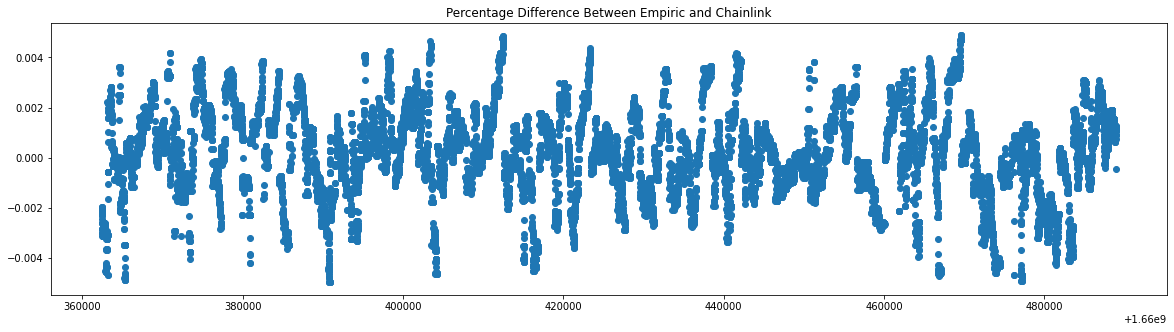

In [205]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_empiric["timestamp_empiric"], combined_empiric["percentage_difference"])
plt.title("Percentage Difference Between Empiric and Chainlink")
plt.show()

In [213]:
max(combined_empiric["percentage_difference"])

0.014746925200734144

In [220]:
# Then find the Chainlink datapoint for benchmarking precision
chainlink = chainlink.sort_values("timestamp").reset_index(drop=True)
stork["last_chainlink_timestamp"] = 0
last_chainlink_timestamp_index = 0
last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]
for i, row in stork.iterrows():
    if last_chainlink_timestamp > time_window[1] or last_chainlink_timestamp_index+1 >= len(chainlink):
        break # Reached end of time window
    if row["timestamp"] > chainlink.loc[last_chainlink_timestamp_index+1, "timestamp"]: # Move on to next timestamp
        last_chainlink_timestamp_index += 1
        last_chainlink_timestamp = chainlink.loc[last_chainlink_timestamp_index, "timestamp"]

    stork.loc[i, "last_chainlink_timestamp"] = last_chainlink_timestamp

In [221]:
combined_stork = pd.merge(chainlink, stork, left_on='timestamp', right_on="last_chainlink_timestamp", how='inner', suffixes=["_chainlink", "_stork"])
combined_stork["difference"] = combined_stork["value_stork"] - combined_stork["value_chainlink"]
combined_stork["percentage_difference"] = combined_stork["difference"] / combined_stork["value_chainlink"]
combined_stork = combined_stork[combined_stork["timestamp_chainlink"] < combined_stork["timestamp_stork"]]
combined_stork

,value_chainlink,timestamp_chainlink,datetime_chainlink,asset,value_stork,timestamp_stork,publisher,type,datetime_stork,last_chainlink_timestamp,difference,percentage_difference
3,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1982.577160,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:51:10,1660362370,-5.712840,-0.002873
4,1988.290000,1660362370,2022-08-13 03:46:10,1.951444e+16,1985.043269,1.660363e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 03:57:10,1660362370,-3.246731,-0.001633
5,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1992.241509,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:09:10,1660363136,0.463458,0.000233
6,1991.778051,1660363136,2022-08-13 03:58:56,1.951444e+16,1991.161022,1.660364e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:12:10,1660363136,-0.617028,-0.000310
7,2003.353785,1660364702,2022-08-13 04:25:02,1.951444e+16,1996.648492,1.660365e+09,25789180169021501187677569358,1.953064e+09,2022-08-13 04:33:10,1660364702,-6.705293,-0.003347
...,...,...,...,...,...,...,...,...,...,...,...,...
272,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.590398,1.660486e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:06:10,1660485315,2.010398,0.001016
273,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1982.350588,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:15:09,1660485315,2.770588,0.001400
274,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1984.556139,1.660487e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:24:10,1660485315,4.976139,0.002514
275,1979.580000,1660485315,2022-08-14 13:55:15,1.951444e+16,1981.470368,1.660489e+09,25789180169021501187677569358,1.953064e+09,2022-08-14 14:54:09,1660485315,1.890368,0.000955


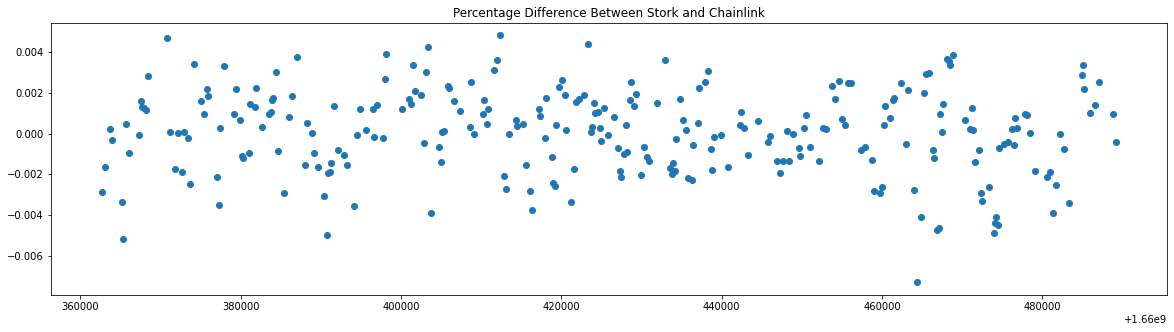

In [222]:
plt.figure(figsize=(20, 5))
plt.scatter(combined_stork["timestamp_stork"], combined_stork["percentage_difference"])
plt.title("Percentage Difference Between Stork and Chainlink")
plt.show()

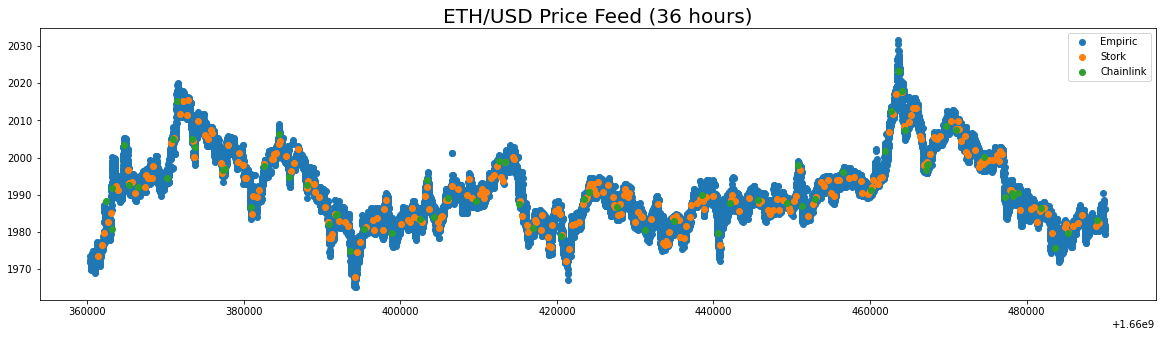

In [224]:
plt.figure(figsize=(20, 5))
for dataset, label in datasets:
    plt.scatter(dataset["timestamp"], dataset["value"], label=label)

plt.title("ETH/USD Price Feed (36 hours)", fontsize=20)
plt.legend()
plt.show()

In [223]:
max(combined_stork["percentage_difference"])

0.004830634689614337